<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [2]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

## 1.1 Connect Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [5]:
# Google Colab
# !pip install keras_cv

In [6]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/mgalao/Library/CloudStorage/OneDrive-NOVAIMS/MSc_DSAA-DS/2nd Semester/Q3 Deep Learning/deep-learning-project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same.

In [8]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [9]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

In [10]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/valid_df.pkl", "rb") as f:
     val_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

with open("family_encoder.pkl", "rb") as f:
     family_encoder = pickle.load(f)

with open("phylum_encoder.pkl", "rb") as f:
     phylum_encoder = pickle.load(f)

In [11]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor_with_phylum(image_size=image_size, batch_size=batch_size)

In [12]:
# identify the minority class
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class = minority_class.to_list()

# Load training data with oversampling and mixup augmentation
train_ds, family_class_names, phylum_class_names = preprocess.load_img(
    train_df, 
    minority_class=minority_class, 
    family_encoder=family_encoder, 
    phylum_encoder=phylum_encoder, 
    shuffle=True, 
    augment='mixup', 
    oversampling=True
)

# Load validation and test data without augmentation or oversampling
val_ds, _, _ = preprocess.load_img(
    val_df, 
    minority_class=minority_class, 
    family_encoder=family_encoder, 
    phylum_encoder=phylum_encoder, 
    shuffle=False, 
    augment=None, 
    oversampling=False
)
test_ds, _, _ = preprocess.load_img(
    test_df, 
    minority_class=minority_class, 
    family_encoder=family_encoder, 
    phylum_encoder=phylum_encoder, 
    shuffle=False, 
    augment=None, 
    oversampling=False
)

In [13]:
# num_images = 16 ##
# rows, cols = 4, 4 ##

# plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

<div class="alert alert-block alert-success">

# **3.** Models

<div>

## EfficientNet + Phylum

### Model

In [ ]:
        #     ┌────────────────────┐
        #     │  image_input (224x224x3)
        #     └─────────┬──────────┘
        #               │
        #      Pretrained Efficient (no top)
        #               │
        # GlobalAveragePooling2D (→ 2048)
        #   - 2048 = number of filters in the final convolutional layer of ResNet50.
        #   - GlobalAveragePooling2D averages over 7×7 spatial grid, giving a single 2048-element feature vector per image.

        #               │
        #               ▼
        #        ┌───────────────┐
        #        │ image features│
        #        └──────┬────────┘
        #               │
        #     ┌─────────▼────────┐
        #     │ phylum_input (5,)│
        #     └─────────┬────────┘
        #               │
        #       Concatenate (→ 2048+5)
        #               │
        #       Dense(256, ReLU)
        #               │
        #          Dropout(0.3)
        #               │
        #    Dense(202, Softmax Output)
        #               │
        #               ▼
        #    Final prediction (family)

In [17]:
# Image input pipeline
image_input = Input(shape=(224, 224, 3), name="image_input")  # Input for RGB image
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=image_input)  # Pretrained EfficientNet without final dense layers

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert 4D feature map to 2D vector (batch_size, 2048)

# Phylum input (one-hot or multi-class vector with 5 classes)
phylum_input = Input(shape=(5,), name="phylum_input")  # Input for phylum-level info

# Combine image and phylum features
combined = Concatenate()([x, phylum_input])  # Concatenate the two inputs: (batch_size, 2048 + 5)
combined = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(combined)  # Fully connected layer
combined = Dropout(0.5)(combined)  # Dropout for regularization
output = Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(combined)  # Final classification layer (202 family classes)

# Define the model
model = Model(inputs=[image_input, phylum_input], outputs=output)

# Compile with metrics
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

# Print the model summary
# model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="eff-net_with_phylum",
    resume=False,
    phylum=True,
)

# Define the learning rate scheduler function
initial_lr = 1e-4
final_lr = 1e-5
n_epochs = 70

my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Define additional callbacks
callbacks_additional = [
    lr_callback,
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Run the experiment
# resume=False means start from scratch, resume=True means continue from last checkpoint)
# callbacks=None use default callbacks (created in the Experiment class)
history = experiment.run_experiment(callbacks=callbacks_additional, epochs=50)

Epoch 1/50


2025-04-24 02:02:17.164767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 948 of 8388
2025-04-24 02:02:37.091817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 2797 of 8388
2025-04-24 02:02:47.108144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 3579 of 8388
2025-04-24 02:02:57.121997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 4449 of 8388
2025-04-24 02:03:07.150254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:2,RepeatDataset:3): Filling up shuffle buffer (this may take a while): 5547 of 8388


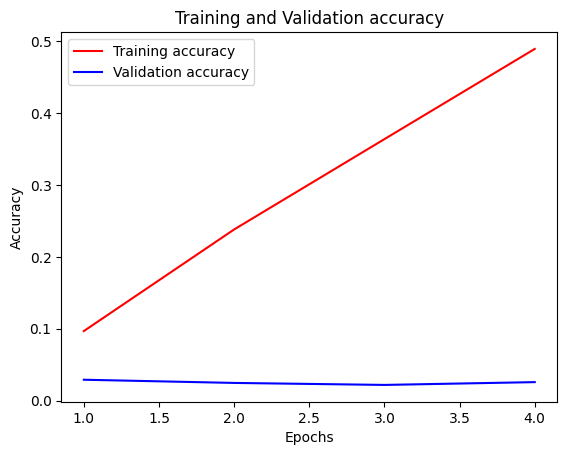

In [19]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=4, train_acc=acc_train, val_acc=acc_val)

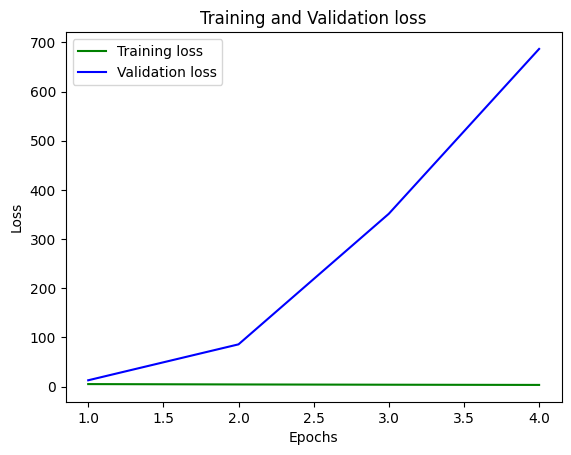

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plot_model_loss(num_epochs=4, train_loss=loss_train, val_loss=loss_val)

In [21]:
x_axis = range(1,4+1)
plt.plot(x_axis, history.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

KeyError: 'f1_score'

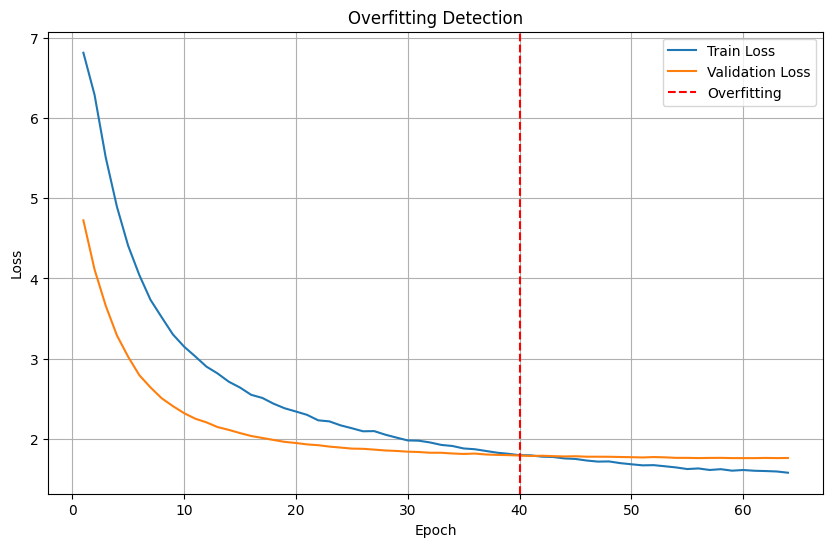

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = range(1, len(loss_train) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Train Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.axvline(x=40, color='r', linestyle='--', label='Overfitting')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overfitting Detection')
plt.legend()
plt.grid(True)
plt.show()

## Margarida

### Base line (without preprocessing and without regularization)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [ ]:
# Load datasets
train_ds_baseline1, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment=None,
    oversampling=False,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds_baseline1, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(202, activation='softmax')(x)

model_baseline1 = models.Model(inputs=base_model.input, outputs=x)

model_baseline1.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=metrics
)

In [ ]:
experiment_baseline1 = Experiment(
    model=model_baseline1,
    train_ds=train_ds_baseline1,
    val_ds=val_ds_baseline1,
    experiment_name="Efficient_net_baseline1",
    batch_size=32,
    image_size=(224, 224)
)

In [ ]:
history_baseline1 = experiment_baseline1.run_experiment(callbacks=None, epochs=25)

No checkpoint found, starting from scratch.
Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 360ms/step - acc: 0.3534 - auc: 0.9424 - f1_score: 0.2043 - loss: 3.2932 - val_acc: 0.3968 - val_auc: 0.9478 - val_f1_score: 0.2444 - val_loss: 2.9208
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 135s 510ms/step - acc: 0.4381 - auc: 0.9638 - f1_score: 0.2921 - loss: 2.6855 - val_acc: 0.4674 - val_auc: 0.9595 - val_f1_score: 0.3188 - val_loss: 2.4960
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 101s 381ms/step - acc: 0.5238 - auc: 0.9739 - f1_score: 0.3923 - loss: 2.2544 - val_acc: 0.5153 - val_auc: 0.9692 - val_f1_score: 0.3788 - val_loss: 2.1885
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 98s 372ms/step - acc: 0.5865 - auc: 0.9825 - f1_score: 0.4751 - loss: 1.9269 - val_acc: 0.5543 - val_auc: 0.9727 - val_f1_score: 0.4284 - val_loss: 1.9627
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 141s 535ms/step - acc: 0.6333 - auc: 0.9858 - f1_score: 0.5385 - loss: 1.6840 - val_acc: 0.5860 - val_auc: 0.9758 - val_f1_score: 0.48

In [ ]:
df_history_baseline1 = pd.DataFrame(history_baseline1.history)
df_history_baseline1.to_csv('efficient_net_baseline1_history.csv', index=False)

### Base line (without preprocessing and with regularization)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)


In [ ]:
# Load datasets
train_ds_baseline2, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=[],
    augment=None,
    oversampling=False,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds_baseline2, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


In [ ]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x) # regularization parameter
x = layers.Dropout(0.5)(x) # regularization layer
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

baseline_model2 = models.Model(inputs=base_model.input, outputs=x)

baseline_model2.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01), # regularization parameter
    metrics=metrics
)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

In [ ]:
experiment_baseline2 = Experiment(
    model=baseline_model2,
    train_ds=train_ds_baseline2,
    val_ds=val_ds_baseline2,
    experiment_name="Efficient_net_baseline2",
    batch_size=32,
    image_size=(224, 224)
)

history_baseline2 = experiment_baseline2.run_experiment(callbacks=callbacks, epochs=50)

Resuming training from epoch 11
Epoch 12/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 114s 404ms/step - acc: 0.5090 - auc: 0.9652 - f1_score: 0.3633 - loss: 2.2868 - val_acc: 0.5492 - val_auc: 0.9708 - val_f1_score: 0.3895 - val_loss: 2.1670 - learning_rate: 7.5858e-05
Epoch 13/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 85s 322ms/step - acc: 0.5210 - auc: 0.9692 - f1_score: 0.3878 - loss: 2.2065 - val_acc: 0.5576 - val_auc: 0.9716 - val_f1_score: 0.4066 - val_loss: 2.1109 - learning_rate: 7.4131e-05
Epoch 14/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 96s 366ms/step - acc: 0.5412 - auc: 0.9694 - f1_score: 0.4073 - loss: 2.1418 - val_acc: 0.5704 - val_auc: 0.9731 - val_f1_score: 0.4249 - val_loss: 2.0598 - learning_rate: 7.2444e-05
Epoch 15/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step - acc: 0.5484 - auc: 0.9724 - f1_score: 0.4199 - loss: 2.0935 - val_acc: 0.5748 - val_auc: 0.9739 - val_f1_score: 0.4367 - val_loss: 2.0137 - learning_rate: 7.0795e-05
Epoch 16/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 87s 327ms/step - acc: 0.5592 -

In [ ]:
df_history_baseline2 = pd.DataFrame(history_baseline2.history)
df_history_baseline2.to_csv('efficient_net_baseline2_history.csv', index=False)

### Set-up

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [ ]:
# Load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train",
    minority_class=minority_class,
    augment='mixup',
    oversampling=True,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


### Head Train

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 1e-5
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)



In [ ]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    lr_callback
]

In [ ]:
experiment_en = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="efficient_net_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler",
    batch_size=32,
    image_size=(224, 224)
)


In [ ]:
history_en = experiment_en.run_experiment(callbacks=callbacks_additional, epochs=50)

No checkpoint found, starting from scratch.
Epoch 1/50


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2153']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


350/350 ━━━━━━━━━━━━━━━━━━━━ 178s 468ms/step - acc: 0.0219 - auc: 0.5791 - f1_score: 0.0109 - loss: 5.3607 - val_acc: 0.2204 - val_auc: 0.8191 - val_f1_score: 0.0810 - val_loss: 4.5216 - learning_rate: 9.6891e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 130s 370ms/step - acc: 0.1629 - auc: 0.7866 - f1_score: 0.0703 - loss: 4.5532 - val_acc: 0.3122 - val_auc: 0.9071 - val_f1_score: 0.1592 - val_loss: 3.8685 - learning_rate: 9.3880e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 145s 413ms/step - acc: 0.2452 - auc: 0.8742 - f1_score: 0.1391 - loss: 3.9729 - val_acc: 0.3639 - val_auc: 0.9406 - val_f1_score: 0.2160 - val_loss: 3.4068 - learning_rate: 9.0961e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 117s 332ms/step - acc: 0.3084 - auc: 0.9111 - f1_score: 0.1979 - loss: 3.5632 - val_acc: 0.4118 - val_auc: 0.9576 - val_f1_score: 0.2705 - val_loss: 3.0579 - learning_rate: 8.8134e-05
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 129s 367ms/step - acc: 0.3605 - auc: 0.9337 - f1_score: 0.2553 - loss: 3.21

In [ ]:
df_history_en = pd.DataFrame(history_en.history)
df_history_en.to_csv('efficient_net_final_train_history.csv', index=False)

In [ ]:
model.save("efficient_net_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras")

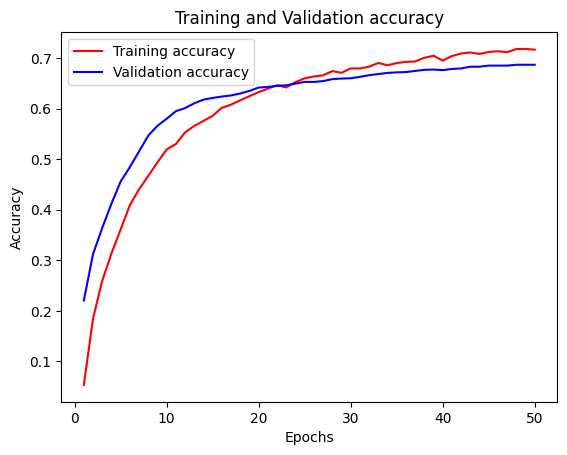

In [ ]:
acc_train_en = history_en.history['acc']
acc_val_en = history_en.history['val_acc']
plot_model_acc(num_epochs=50, train_acc=acc_train_en, val_acc=acc_val_en)

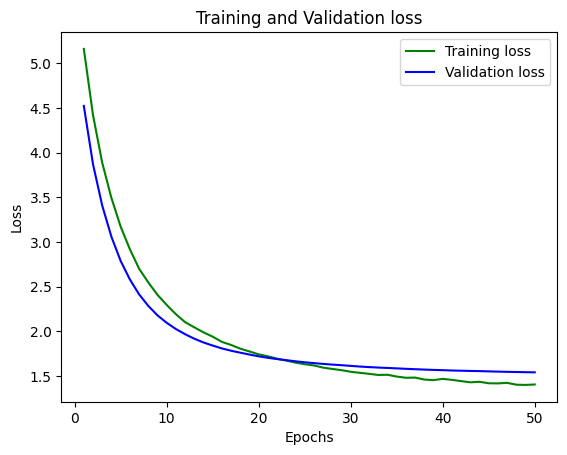

In [ ]:
loss_train_en = history_en.history['loss']
loss_val_en = history_en.history['val_loss']
plot_model_loss(num_epochs=50, train_loss=loss_train_en, val_loss=loss_val_en)

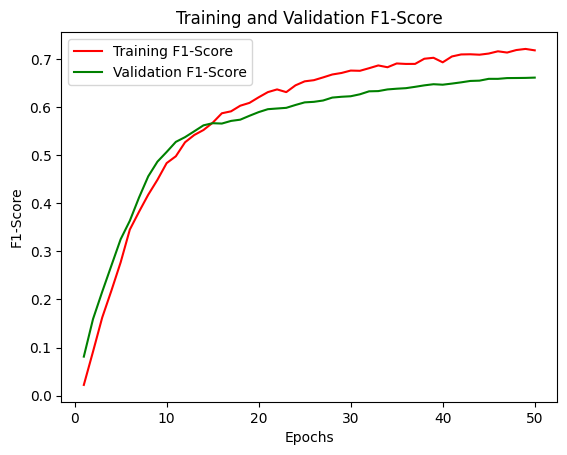

In [ ]:
x_axis = range(1,50+1)
plt.plot(x_axis, history_en.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history_en.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

### Fine-tune

In [ ]:
base_model_ft_en = load_model("efficient_net_pre_finetuning_with_label_smoothing_batch_sized_corrected_launching_trying_lr_scheduler.keras", compile=False)

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-5
final_lr = 1e-6
n_epochs = 100
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)



In [ ]:
progressive_unfreeze = ProgressiveUnfreeze(base_model_ft_en)

base_model_ft_en.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [ ]:
experiment_ft = Experiment(
    model=base_model_ft_en,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="efficientnet_finetune_c",
    batch_size=32,
    image_size=(224, 224),
    save_model=True
)

history_ft_en = experiment_ft.run_experiment(
    epochs=100,
    callbacks=[progressive_unfreeze, lr_callback]
)

No checkpoint found, starting from scratch.
Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - acc: 0.7133 - auc: 0.9891 - f1_score: 0.6941 - loss: 1.4267Epoch 0: Layer now unfrozen 241 (dense_7)
350/350 ━━━━━━━━━━━━━━━━━━━━ 113s 306ms/step - acc: 0.7133 - auc: 0.9891 - f1_score: 0.6942 - loss: 1.4267 - val_acc: 0.6867 - val_auc: 0.9801 - val_f1_score: 0.6611 - val_loss: 1.5418 - learning_rate: 9.7724e-06
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 104s 296ms/step - acc: 0.7269 - auc: 0.9894 - f1_score: 0.7065 - loss: 1.4045 - val_acc: 0.6878 - val_auc: 0.9801 - val_f1_score: 0.6624 - val_loss: 1.5405 - learning_rate: 9.5499e-06
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - acc: 0.7130 - auc: 0.9893 - f1_score: 0.6895 - loss: 1.4263Epoch 2: Layer now unfrozen 240 (dropout_3)
350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 286ms/step - acc: 0.7130 - auc: 0.9893 - f1_score: 0.6896 - loss: 1.4262 - val_acc: 0.6889 - val_auc: 0.9799 - val_f1_score: 0.6628 - val_loss: 1.5397 - learning_rate

In [ ]:
base_model_ft_en.save("efficient_net_finetuned_final.keras")

In [ ]:
test_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/test",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 1798 files belonging to 202 classes.


In [ ]:
base_model_ft_en.evaluate(test_ds)

57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - acc: 0.7113 - auc: 0.9231 - f1_score: 0.3195 - loss: 1.3660


[1.470661997795105, 0.7018910050392151, 0.964812159538269, 0.6690705418586731]

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

y_true = []
y_pred = []

for batch_x, batch_y in test_ds:
    preds = base_model_ft_en.predict(batch_x)
    y_true.append(np.argmax(batch_y.numpy(), axis=1))
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(y_true, y_pred, digits=4))

print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))
print("Accuracy :", accuracy_score(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-04-23 10:24:26.849485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: Und

In [ ]:
history_ft_en = pd.DataFrame(history_ft_en.history)
history_ft_en.to_csv('efficient_net_final_finetune_history.csv', index=False)